In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *

Console_and_file_logger('split_dataset', logging.INFO)
from sklearn.model_selection import train_test_split
from src.utils.utils_io import ensure_dir


%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


2020-07-23 16:28:41,530 INFO -------------------- Start --------------------
2020-07-23 16:28:41,531 INFO Working directory: /mnt/data/git/cardio.
2020-07-23 16:28:41,531 INFO Log file: ./logs/split_dataset.log
2020-07-23 16:28:41,532 INFO Log level for console: INFO


## Split a dataset in train, val, test

In [2]:
# split (train, val, test) files in a given directory
input_path = 'data/raw/gcn_05_2020/4d_export/SAx/'
export_path = 'data/raw/gcn_05_2020/4D/'

## Get all filenames

In [3]:
# splitting with shuffle and seed
# first split train / test, then split train / validation
images = sorted(glob.glob(os.path.join(input_path, '*clean.nrrd')))
masks = sorted(glob.glob(os.path.join(input_path, '*mask.nrrd')))
"images", len(images)
"masks", len(masks)

('images', 61)

('masks', 61)

In [4]:
import SimpleITK as sitk
img = sitk.ReadImage(masks[0])
nda = sitk.GetArrayFromImage(img)
nda.shape

(25, 18, 256, 256)

In [5]:
nda.flatten().shape[0]

nda[nda==0].shape[0]

nda[nda==1].shape[0]

nda[nda==2].shape[0]

nda[nda==3].shape[0]

29491200

29377423

55919

22813

35045

## Class weightings

In [6]:
# background
(100.0/nda.flatten().shape[0])*nda[nda==0].shape[0]

# RV
(100.0/nda.flatten().shape[0])*nda[nda==1].shape[0]

# Myo
(100.0/nda.flatten().shape[0])*nda[nda==2].shape[0]

# LV
(100.0/nda.flatten().shape[0])*nda[nda==3].shape[0]

99.61420016818576

0.18961249457465276

0.07735527886284722

0.1188320583767361

## Split dataset

In [8]:
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.25, random_state=seed)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=seed)

print('4D Dataset split')
print('Dataset: images: {}, masks: {} '.format(len(images), len(masks)))
print('X_train: {}, Y_train: {}'.format(len(X_train), len(Y_train)))
print('X_val: {}, Y_val: {}'.format(len(X_val), len(Y_val)))
print('X_test: {}, Y_test: {}'.format(len(X_test), len(Y_test)))

4D Dataset split
Dataset: images: 61, masks: 61 
X_train: 45, Y_train: 45
X_val: 8, Y_val: 8
X_test: 8, Y_test: 8


## Define paths

In [9]:

img_train_path = '{}{}'.format(export_path, 'train/images/')
img_val_path = '{}{}'.format(export_path, 'val/images/')
img_test_path = '{}{}'.format(export_path, 'test/images/')
mask_train_path = '{}{}'.format(export_path, 'train/masks/')
mask_val_path = '{}{}'.format(export_path, 'val/masks/')
mask_test_path = '{}{}'.format(export_path, 'test/masks/')


IMPORT = pd.DataFrame(
    index=[
        'import_img', 'import_mask', 'img_train', 'img_val', 'img_test',
        'mask_train', 'mask_val', 'mask_test'
    ],
    columns=['Paths', 'Files', 'Data', 'Copied'])

IMPORT['Paths'] = [input_path, input_path, 
                   img_train_path, img_val_path, img_test_path, 
                   mask_train_path, mask_val_path, mask_test_path]

IMPORT['Files'] = [
    len(images),
    len(masks),
    len(X_train),
    len(X_val),
    len(X_test),
    len(Y_train),
    len(Y_val),
    len(Y_test)
]

IMPORT['Data'] = [
    images,
    masks,
    X_train,
    X_val,
    X_test,
    Y_train,
    Y_val,
    Y_test
]


IMPORT

,Paths,Files,Data,Copied
import_img,data/raw/gcn_05_2020/4d_export/SAx/,61,[data/raw/gcn_05_2020/4d_export/SAx/0000-8NFJ8...,NaN
import_mask,data/raw/gcn_05_2020/4d_export/SAx/,61,[data/raw/gcn_05_2020/4d_export/SAx/0000-8NFJ8...,NaN
img_train,data/raw/gcn_05_2020/4D/train/images/,45,[data/raw/gcn_05_2020/4d_export/SAx/0000-9HQPR...,NaN
img_val,data/raw/gcn_05_2020/4D/val/images/,8,[data/raw/gcn_05_2020/4d_export/SAx/0000-F0QP6...,NaN
img_test,data/raw/gcn_05_2020/4D/test/images/,8,[data/raw/gcn_05_2020/4d_export/SAx/0000-8NFJ8...,NaN
mask_train,data/raw/gcn_05_2020/4D/train/masks/,45,[data/raw/gcn_05_2020/4d_export/SAx/0000-9HQPR...,NaN
mask_val,data/raw/gcn_05_2020/4D/val/masks/,8,[data/raw/gcn_05_2020/4d_export/SAx/0000-F0QP6...,NaN
mask_test,data/raw/gcn_05_2020/4D/test/masks/,8,[data/raw/gcn_05_2020/4d_export/SAx/0000-8NFJ8...,NaN


In [10]:
# define a helper copy function
def copy_volumes(files, destination_path):
    """
    Copy all files named in files to the destination path
    files: list of full file paths as strings
    destination_path: root destination folder as string
    """
    import shutil
    
    logging.info('Start to copy: {} files'.format(len(files)))
    # ensure directory exist
    ensure_dir(destination_path)
    
    for file in files:
        logging.info('copy file: {} to {}'.format(file, destination_path))
        shutil.copy2(file, destination_path)
    
    # get all nrrd files in the destination directory
    copied_files = glob.glob(os.path.join(destination_path, '*.nrrd'))
    
    logging.info('Copy finished, found {} files in destination path {}'.format(len(copied_files), destination_path))
    IMPORT.loc[IMPORT['Paths'] == destination_path] = len(copied_files)

## Copy and split data

In [11]:
# slice the dataframe, 
files_to_copy = IMPORT[2:8]
# copy all data
[copy_volumes(row['Data'], row['Paths']) for index, row in files_to_copy.iterrows()]

2020-05-05 14:34:54,384 INFO Start to copy: 45 files
2020-05-05 14:34:54,384 INFO copy file: data/raw/gcn_05_2020/4d_export/SAx/0000-9HQPRPDH_2006-01-31_volume_clean.nrrd to data/raw/gcn_05_2020/4D/train/images/
2020-05-05 14:34:54,486 INFO copy file: data/raw/gcn_05_2020/4d_export/SAx/0000-91GEVV22_1900-01-01_volume_clean.nrrd to data/raw/gcn_05_2020/4D/train/images/
2020-05-05 14:34:54,495 INFO copy file: data/raw/gcn_05_2020/4d_export/SAx/0000-E2HMADJ3_2007-03-27_volume_clean.nrrd to data/raw/gcn_05_2020/4D/train/images/
2020-05-05 14:34:54,583 INFO copy file: data/raw/gcn_05_2020/4d_export/SAx/0000-8URYP1JA_2005-12-15_volume_clean.nrrd to data/raw/gcn_05_2020/4D/train/images/
2020-05-05 14:34:54,597 INFO copy file: data/raw/gcn_05_2020/4d_export/SAx/0000-EAT4PL0E_2005-11-23_volume_clean.nrrd to data/raw/gcn_05_2020/4D/train/images/
2020-05-05 14:34:54,652 INFO copy file: data/raw/gcn_05_2020/4d_export/SAx/0000-AX28HN78_2007-02-14_volume_clean.nrrd to data/raw/gcn_05_2020/4D/train/i

[None, None, None, None, None, None]

In [12]:
IMPORT

,Paths,Files,Data,Copied
import_img,data/raw/gcn_05_2020/4d_export/SAx/,61,[data/raw/gcn_05_2020/4d_export/SAx/0000-8NFJ8...,NaN
import_mask,data/raw/gcn_05_2020/4d_export/SAx/,61,[data/raw/gcn_05_2020/4d_export/SAx/0000-8NFJ8...,NaN
img_train,45,45,45,45
img_val,8,8,8,8
img_test,8,8,8,8
mask_train,45,45,45,45
mask_val,8,8,8,8
mask_test,8,8,8,8


# Tests split data for crossvalidation

# Test if all files are covered by each fold

In [2]:
from src.data.Dataset import get_kfolded_data, get_patient

Using TensorFlow backend.


In [3]:
df_folds = get_kfolded_data(kfolds=4, path_to_data='data/raw/gcn_05_2020/SAx_2D', extract_patient_id=get_patient)

In [4]:
test_1 = set(df_folds[df_folds['fold']==0]['x_path'])

In [5]:
test_2 = set(df_folds[df_folds['fold']==1]['x_path'])

In [6]:
test_1 == test_2

True

In [7]:
df_folds.head()

,fold,x_path,y_path,modality,patient
0,3,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,train,0000-02Z1L14N_2006-11-09
1,3,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,train,0000-02Z1L14N_2006-11-09
2,3,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,train,0000-02Z1L14N_2006-11-09
3,3,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,train,0000-02Z1L14N_2006-11-09
4,3,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,data/raw/gcn_05_2020/SAx_2D/0000-02Z1L14N_2006...,train,0000-02Z1L14N_2006-11-09


In [8]:
# splitting grouped by patients
df_folds.groupby(['fold', 'modality'])['patient'].nunique()

fold  modality
0     test         70
      train       208
1     test         70
      train       208
2     test         69
      train       209
3     test         69
      train       209
Name: patient, dtype: int64

In [9]:
# splitting grouped by slices 
df_folds.groupby(['fold', 'modality']).count()

x_path  y_path  patient
fold modality                         
0    test        4823    4823     4823
     train      14697   14697    14697
1    test        4902    4902     4902
     train      14618   14618    14618
2    test        4780    4780     4780
     train      14740   14740    14740
3    test        5015    5015     5015
     train      14505   14505    14505

In [10]:
# save dataframe
df_folds.to_csv('data/raw/gcn_05_2020/SAx_2D_df_kfold.csv')

# Tests for splitting the ACDC dataset by pathologie

In [2]:
from src.data.Dataset import get_acdc_dataset_as_df, create_acdc_dataframe_for_cv

Using TensorFlow backend.


In [3]:
df = get_acdc_dataset_as_df('data/raw/ACDC/original/all/')

In [4]:
df.head(21)

,index,pathology,patient,files,phase
0,0,DCM,patient001,data/raw/ACDC/original/all/patient001/Info.cfg,cfg
1,1,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,ed
2,2,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,ed_gt
3,3,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,es
4,4,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,es_gt
5,5,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,4d
6,0,DCM,patient002,data/raw/ACDC/original/all/patient002/Info.cfg,cfg
7,1,DCM,patient002,data/raw/ACDC/original/all/patient002/patient0...,ed
8,2,DCM,patient002,data/raw/ACDC/original/all/patient002/patient0...,ed_gt
9,3,DCM,patient002,data/raw/ACDC/original/all/patient002/patient0...,es


# Kfold per pathologie

In [8]:
# create a kfold df from a 2D directory, split by patient
df_folds = create_acdc_dataframe_for_cv(path_to_data='data/raw/ACDC/3D')

In [6]:
df_folds.head()

,fold,modality,pathology,patient,x_path,y_path
0,3,train,RV,patient081,data/raw/ACDC/2D/all/patient081__t01_z0_img.nrrd,data/raw/ACDC/2D/all/patient081__t01_z0_msk.nrrd
1,3,train,RV,patient081,data/raw/ACDC/2D/all/patient081__t01_z10_img.nrrd,data/raw/ACDC/2D/all/patient081__t01_z10_msk.nrrd
2,3,train,RV,patient081,data/raw/ACDC/2D/all/patient081__t01_z11_img.nrrd,data/raw/ACDC/2D/all/patient081__t01_z11_msk.nrrd
3,3,train,RV,patient081,data/raw/ACDC/2D/all/patient081__t01_z12_img.nrrd,data/raw/ACDC/2D/all/patient081__t01_z12_msk.nrrd
4,3,train,RV,patient081,data/raw/ACDC/2D/all/patient081__t01_z13_img.nrrd,data/raw/ACDC/2D/all/patient081__t01_z13_msk.nrrd


In [7]:

df_folds.groupby(['fold', 'modality'])['patient'].nunique()

fold  modality
0     test        25
      train       75
1     test        25
      train       75
2     test        25
      train       75
3     test        25
      train       75
Name: patient, dtype: int64

In [9]:
# create a kfold df from a 2D dataframe and 3D files, hack to be consistent with the 2D splitting, necessary for combined 2D /3D networks
df_folds = pd.read_csv('data/raw/ACDC/2D/df_kfold.csv')

In [10]:
from src.data.Dataset import read_cfg_file
files_3d = glob.glob('data/raw/ACDC/3D/**/**/*frame[0-9][0-9].nii.gz')
print(len(files_3d))
rows = []
folds = []
for fold in df_folds.fold.unique():
    df_fold = df_folds[df_folds['fold'] == fold].copy()
    for vol in files_3d:
        # get patient name from pathname
        patient = vol.split('/')[-2]
        # get one row from df_2d
        row = df_fold[df_fold['patient'] ==patient].iloc[0]
        folds.append(row)
        # open the patient cfg
        cfg = read_cfg_file(os.path.join(os.path.dirname(vol),'Info.cfg'))
        # get the frame of this 3D vol
        frame = os.path.basename(vol).split('frame')[1][:2]
        phase = 'ED'
        if int(cfg.get('ES')) == int(frame):
            phase = 'ES'
        # create a new row for this 3d volume
        rows.append([row['fold'], row['modality'], row['pathology'], patient, phase, vol, vol.replace('.nii.gz', '_gt.nii.gz')])
df_3d = pd.DataFrame(rows, columns=['fold', 'modality', 'pathology', 'patient', 'phase', 'x_path', 'y_path'])
df_3d.head()

400


,fold,modality,pathology,patient,phase,x_path,y_path
0,3,train,MINF,patient050,ED,data/raw/ACDC/3D/all/patient050/patient050_fra...,data/raw/ACDC/3D/all/patient050/patient050_fra...
1,3,train,MINF,patient050,ES,data/raw/ACDC/3D/all/patient050/patient050_fra...,data/raw/ACDC/3D/all/patient050/patient050_fra...
2,3,train,NOR,patient070,ED,data/raw/ACDC/3D/all/patient070/patient070_fra...,data/raw/ACDC/3D/all/patient070/patient070_fra...
3,3,train,NOR,patient070,ES,data/raw/ACDC/3D/all/patient070/patient070_fra...,data/raw/ACDC/3D/all/patient070/patient070_fra...
4,3,train,RV,patient100,ES,data/raw/ACDC/3D/all/patient100/patient100_fra...,data/raw/ACDC/3D/all/patient100/patient100_fra...


In [11]:
temp = pd.DataFrame(folds)
df_3d.fold.unique()

array([3, 2, 1, 0])

In [12]:
# save dataframe
df_3d.to_csv('data/raw/ACDC/3D/df_kfold.csv')


In [23]:
df_folds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7608 entries, 0 to 95
Data columns (total 6 columns):
fold         7608 non-null object
modality     7608 non-null object
pathology    7608 non-null object
patient      7608 non-null object
x_path       7608 non-null object
y_path       7608 non-null object
dtypes: object(6)
memory usage: 416.1+ KB


In [24]:
df_folds.head(21)

,fold,modality,pathology,patient,x_path,y_path
0,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z0_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z0_msk.nrrd
1,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z10_img....,data/raw/ACDC/2D/train/patient082_t01_z10_msk....
2,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z11_img....,data/raw/ACDC/2D/train/patient082_t01_z11_msk....
3,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z12_img....,data/raw/ACDC/2D/train/patient082_t01_z12_msk....
4,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z13_img....,data/raw/ACDC/2D/train/patient082_t01_z13_msk....
5,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z14_img....,data/raw/ACDC/2D/train/patient082_t01_z14_msk....
6,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z15_img....,data/raw/ACDC/2D/train/patient082_t01_z15_msk....
7,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z1_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z1_msk.nrrd
8,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z2_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z2_msk.nrrd
9,3,train,RV,patient082,data/raw/ACDC/2D/train/patient082_t01_z3_img.nrrd,data/raw/ACDC/2D/train/patient082_t01_z3_msk.nrrd


In [6]:
# splitting grouped by patients, modality and pathologie
df_folds.groupby(['fold', 'modality', 'pathology'])[['patient']].count()

patient
fold modality pathology         
0    test     DCM             96
              HCM             88
              MINF            80
              NOR             84
              RV             128
     train    DCM            294
              HCM            290
              MINF           266
              NOR            256
              RV             320
1    test     DCM            102
              HCM             88
              MINF            86
              NOR             88
              RV             116
     train    DCM            288
              HCM            290
              MINF           260
              NOR            252
              RV             332
2    test     DCM             96
              HCM             96
              MINF            94
              NOR             72
              RV              92
     train    DCM            294
              HCM            282
              MINF           252
              NOR            268
              RV             356
3    test     DCM             96
              HCM            106
              MINF            86
              NOR             96
              RV             112
     train    DCM            294
              HCM            272
              MINF           260
              NOR            244
              RV             336

# How many patients per pathology, how many slices per pathology?

In [7]:
len(df_folds['patient'].unique())

100

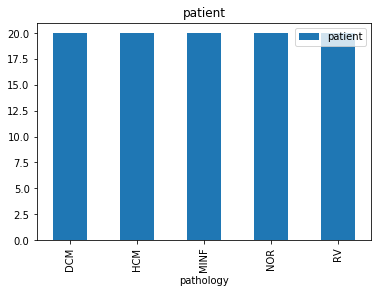

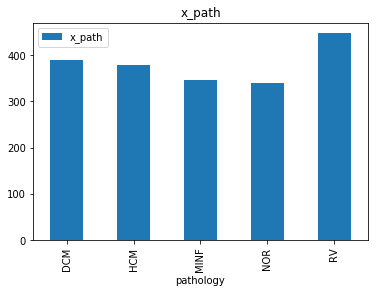

In [8]:
# How many patients per pathologie
fold = 1

df_folds[(df_folds['fold'] == fold)].groupby(['pathology'])[['patient']].nunique().plot(kind='bar', subplots=True);
# how many slices from each pathologie
df_folds[(df_folds['fold'] == fold)].groupby(['pathology'])[['x_path']].count().plot(kind='bar', subplots=True);

# compare files of each fold to make sure, each fold has all files

In [9]:
set(df_folds[df_folds['fold'] == 0]['y_path']) == set(df_folds[df_folds['fold'] == 1]['y_path'])

True

In [10]:
# save df to disk for later usage in train with folds
kfold_data_dir = 'reports/kfolds_data/2D/acdc/'
df_folds.to_csv(os.path.join(kfold_data_dir, 'df_kfold.csv'))
#df_folds = pd.read_csv(os.path.join(kfold_data_dir, 'df_kfold.csv'))

# Visualise the folded data to make sure nothing is messed up

# Choose fold

In [34]:
from src.data.generators import DataGenerator
# define global batch_generator
batch_generator = None
@interact
def choose_fold(fold=sorted(df_folds['fold'].unique())):
    global batch_generator
    df_fold = df_folds[df_folds['fold'] == fold]
    x = sorted(df_fold['x_path'])
    y = sorted(df_fold['y_path'])
    
    logging.info('x: {}, y: {}'.format(len(x), len(y)))
    logging.info('{}'.format(x[:5]))
    logging.info('{}'.format(y[:5]))
    
    config = {} # create an emty config, standard values should work
    batch_generator = DataGenerator(x, y, config)

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3), value=0), Output()), _dom_classes=('w…

# Choose batch and image

In [35]:
from time import time
from src.visualization.visualize import show_slice_transparent
@interact
def interact_show_with_generator(selected_batch=(0, len(batch_generator)), selected_img=(0, batch_generator.BATCHSIZE)):
    #selected_img = 70
    
    logging.getLogger().setLevel(logging.INFO)
    mpl_logger = logging.getLogger('matplotlib') 
    mpl_logger.setLevel(logging.WARNING) 

    t0 = time()
    x, y = batch_generator.__getitem__(selected_batch)
    logging.info('loading batch: {}, took {:0.3f} sec'.format(selected_batch, time()- t0))
    logging.info('X shape: {}'.format(x.shape))
    logging.info('Y shape: {}'.format(y.shape))
    # plot x and y
    ax = show_slice_transparent(x[selected_img], y[selected_img])

interactive(children=(IntSlider(value=29, description='selected_batch', max=59), IntSlider(value=16, descripti…

# Pathologies per fold per modality in %, #patients and #slices

In [2]:
# load existing split
kfold_data_dir = 'reports/kfolds_data/2D/acdc/'
df_folds = pd.read_csv(os.path.join(kfold_data_dir, 'df_kfold.csv'))
plt.rcParams.update({'font.size': 30})
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

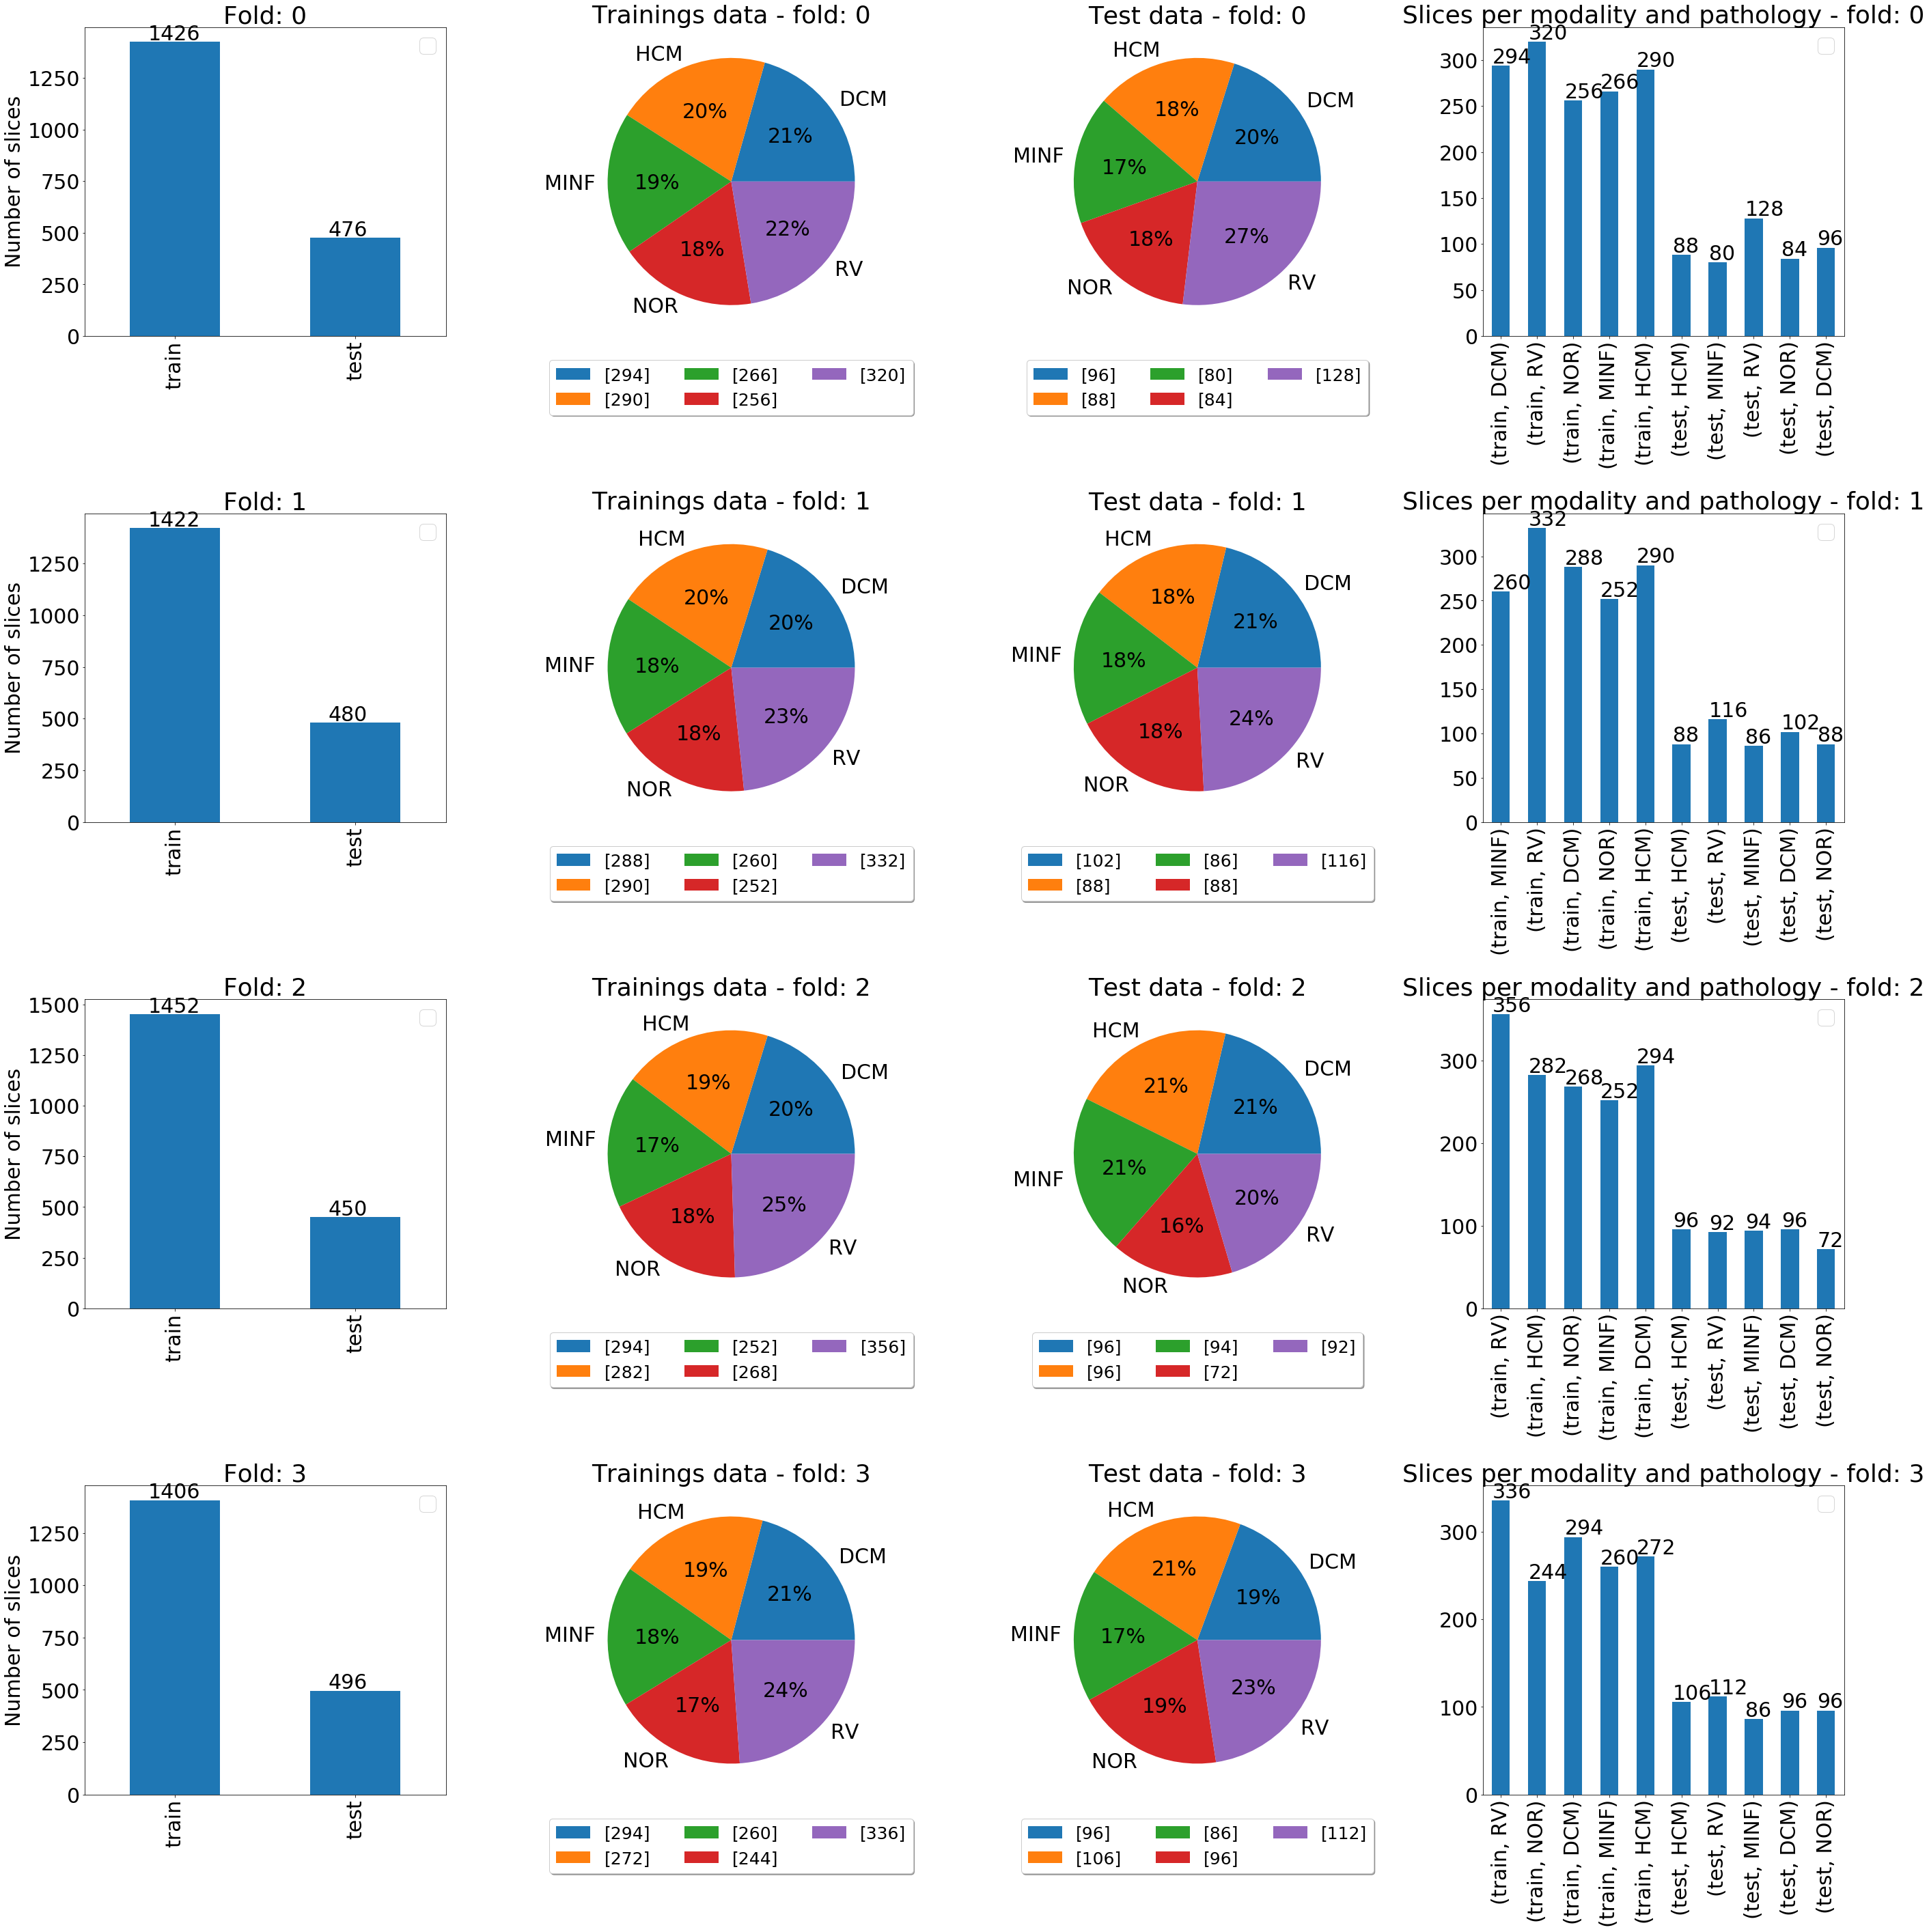

In [6]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

nrows = len(df_folds['fold'].unique())
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 10, nrows * 10))

df_folds.sort_values('modality', inplace=True, ascending=False)

position = 0
for fold in sorted(df_folds['fold'].unique()):
    
    # how many slices per fold per train/validation
    ax_ = df_folds[(df_folds['fold'] == fold)].groupby(['modality'], sort=False)[['modality']].count().plot(kind='bar', subplots=True, ax=axes[position,0])
    for p in ax_[0].patches:
        ax_[0].annotate('{}'.format(str(p.get_height())), (p.get_x() + 0.10, p.get_height() + 10))
    axes[position, 0].legend(labels=[])
    axes[position, 0].set_title('Fold: {}'.format(fold))
    axes[position, 0].set_ylabel('Number of slices')
    axes[position, 0].set_xlabel('')
    
    df_folds[(df_folds['fold'] == fold) & (df_folds['modality'] == 'train')].groupby(['pathology'])[['patient']].count().plot(kind='pie',  subplots=True, ax = axes[position, 1], autopct='%1.0f%%')
    axes[position, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop=fontP, labels=df_folds[(df_folds['fold'] == fold) & (df_folds['modality'] == 'train')].groupby(['pathology'])[['patient']].count().values)
    axes[position, 1].set_title('Trainings data - fold: {}'.format(fold))
    axes[position, 1].set_ylabel('')
    
    df_folds[(df_folds['fold'] == fold) & (df_folds['modality'] == 'test')].groupby(['pathology'])[['patient']].count().plot(kind='pie',  subplots=True, ax = axes[position, 2], autopct='%1.0f%%')
    axes[position, 2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, prop=fontP, labels=df_folds[(df_folds['fold'] == fold) & (df_folds['modality'] == 'test')].groupby(['pathology'])[['patient']].count().values)
    axes[position, 2].set_title('Test data - fold: {}'.format(fold))
    axes[position, 2].set_ylabel('')
    
    
    # how many slices from each pathology
    ax_ = df_folds[(df_folds['fold'] == fold)].groupby(['modality','pathology'], sort=False)[['modality']].count().plot(kind='bar', subplots=True, ax=axes[position,3])
    for p in ax_[0].patches:
        ax_[0].annotate('{}'.format(str(p.get_height())), (p.get_x() + 0.010, p.get_height() + 3))
    axes[position, 3].legend(labels=[])
    axes[position, 3].set_title('Slices per modality and pathology - fold: {}'.format(fold))
    axes[position, 3].set_xlabel('')

    
    position +=1
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()
fig.savefig('reports/acdc_splitting.pdf')

In [44]:
# how many slices do we have per patient in one split?
pd.value_counts(df_folds[(df_folds['fold'] == 0) & (df_folds['modality'] == 'train')]['patient'])

patient099    32
patient088    32
patient092    30
patient085    30
patient075    28
patient095    28
patient035    26
patient043    24
patient084    24
patient006    22
patient019    22
patient013    20
patient050    20
patient005    20
patient094    20
patient007    20
patient040    20
patient008    20
patient014    20
patient028    20
patient093    20
patient030    20
patient012    20
patient026    20
patient004    20
patient033    20
patient003    20
patient071    20
patient051    20
patient067    20
              ..
patient025    18
patient023    18
patient039    18
patient079    18
patient047    18
patient065    16
patient054    16
patient077    16
patient091    16
patient052    16
patient045    16
patient074    16
patient087    16
patient100    16
patient024    16
patient063    16
patient020    16
patient097    16
patient057    16
patient048    16
patient072    16
patient068    14
patient090    14
patient037    14
patient086    14
patient053    14
patient073    14
patient080    

In [46]:
# splitting grouped by slices 
df_folds[(df_folds['fold'] == 0) & (df_folds['modality'] == 'train')].groupby(['fold', 'modality', 'pathology', ])['patient'].nunique().values

array([15, 15, 15, 15, 15])

In [47]:
df_folds['pathology'].unique()

array(['RV', 'MINF', 'DCM', 'NOR', 'HCM'], dtype=object)